# Set-up

## Package management

In [20]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import preprocessing
import scipy.sparse as sp
from scipy import linalg

# --- Network science ---
from cdlib import algorithms
import networkx as nx

# --- Data handling and visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

import seaborn as sns

# --- Miscelleaneous ---
from tqdm.auto import tqdm

# --- Project source code ---
sys.path.append("../../../")
sys.path.append("../../../src/")

# Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import lfr_multiplex  # benchmark samplers

# Sampling
from src.sampling.random import partial_information  # PFI observation

# Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

# Global Config

In [21]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"


In [22]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

# Data set-up

In [23]:
# --- Describing attributes ---
_ATTR_DICT = {
    "N": "number of nodes (in shared node set)",
    "T1": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "KAVG": "average degree (in both layers)",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [24]:
# --- Data/Experiment Configurations ---
class NetworkParams(Enum):
    # Shared params
    N = 1000
    PROB = 1.0
    T1 = 2.1
    KMAX = np.sqrt(1000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    KAVG = 5.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 11, endpoint=True)

LOGREG = {
    "fit_intercept": True,  # include intercept accounting for class imbalance
    "solver": "newton-cholesky",  # uses Cholesky-decomposition to approximate Hessian for Newton-esque method
    "penalty": None  # do not include coefficient regularization
}

## Function set-up

In [50]:
class HOPE:
    """
    Ou, Mingdong, et al. Asymmetric transitivity preserving graph embedding.
    Proceedings of the 22nd ACM SIGKDD international conference on Knowledge
    discovery and data mining. ACM, 2016.

    Implementation borrowed from https://github.com/THUDM/cogdl/blob/master/cogdl/models/emb/hope.py
    with modification
    This implementation use Katz similarity of the nodes, which is claimed to
    be the best in the paper

    HOPE use the numpy linear algebra lib, which by default uses multiple threads.
    To disable it, export OPENBLAS_NUM_THREADS=1 or MKL_NUM_THREADS=1
    in shell depending on the backend of the numpy installation.
    """
    def __init__(self, dimension=128, beta=0.01):
        self.dimension = dimension
        self.beta = beta

    def train(self, G):
        self.G = G
        self.id2node = dict(zip(range(len(G)), G))

        adj = nx.adjacency_matrix(self.G).todense()
        n = adj.shape[0]
        # The author claim that Katz has superior performance in related tasks
        # S_katz = (M_g)^-1 * M_l = (I - beta*A)^-1 * beta*A = (I - beta*A)^-1 * (I - (I -beta*A))
        #        = (I - beta*A)^-1 - I
        katz_matrix = np.asarray((np.eye(n) - self.beta * np.mat(adj)).I - np.eye(n))
        self.embeddings_matrix = self._get_embedding(katz_matrix, self.dimension)
        #center_point = self.embeddings_matrix.mean(axis=0) # centering the coordinates
        #self.embeddings_matrix -= center_point # centering the coordinates
        self.embeddings = {
            # str(self.id2node[i]): self.embeddings_matrix[i] for i in range(len(self.id2node))
            self.id2node[i]: self.embeddings_matrix[i] for i in range(len(self.id2node))
        }

        return self.embeddings

    def _get_embedding(self, matrix, dimension):
        # get embedding from svd and process normalization for ut and vt
        ut, s, vt = sp.linalg.svds(matrix, int(dimension / 2))
        emb_matrix_1, emb_matrix_2 = ut, vt.transpose()

        emb_matrix_1 = emb_matrix_1 * np.sqrt(s)
        emb_matrix_2 = emb_matrix_2 * np.sqrt(s)
        emb_matrix_1 = preprocessing.normalize(emb_matrix_1, "l2")
        emb_matrix_2 = preprocessing.normalize(emb_matrix_2, "l2")
        features = np.hstack((emb_matrix_1, emb_matrix_2))
        return features

In [26]:
def get_network(
        N=int(NetworkParams.N.value),  # number of nodes
        T1=NetworkParams.T1.value,  # degree distribution exponent
        T2=NetworkParams.T2.value,  # community size distribution exponent
        MU=NetworkParams.MU.value,  # community mixing parameter
        KAVG=NetworkParams.KAVG.value,  # average degree
        KMAX=NetworkParams.KMAX.value,  # maximum degree
        MIN_COMMUNITY=NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
        PROB=NetworkParams.PROB.value,  # degree sequence correlation,
        ROOT="../../"):
    duplex, _, _, _ = lfr_multiplex(N, T1, T2, MU, KAVG, KMAX, MIN_COMMUNITY, PROB, ROOT)
    duplex = duplex_network(duplex, 1, 2, verbose=True)

    return duplex

In [27]:
def get_remnants(theta, G, H):
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }

    return record

In [28]:
def embed_remnants_HOPE(
        remnants_record,
        params,
        normalize=True,
        nodelist=None):
    G, H = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    embeddings_G = HOPE(dimension=params["dimension"], beta=params["beta"]).train(G)
    embeddings_H = HOPE(dimension=params["dimension"], beta=params["beta"]).train(H)

    distances_G_train, distances_H_train = get_distances((embeddings_G, embeddings_H), E_train)
    distances_G_test, distances_H_test = get_distances((embeddings_G, embeddings_H), E_test)

    # * >>> Match FR notebook >>>
    # distances_G_train = [x**2 for x in distances_G_train]
    # distances_H_train = [x**2 for x in distances_H_train]
    # distances_G_test = [x**2 for x in distances_G_test]
    # distances_H_test = [x**2 for x in distances_H_test]
    # * <<< Match FR notebook <<<

    feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
    feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

    if normalize:
        normalizer = max(np.abs(feature_distances_train))
        feature_distances_train = list(map(lambda x: x / normalizer, feature_distances_train))

        normalizer = max(np.abs(feature_distances_test))
        feature_distances_test = list(map(lambda x: x / normalizer, feature_distances_test))

    return feature_distances_train, feature_distances_test

In [29]:
def get_degree_features(remnants_record):
    G, H = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees((G, H), E_train)
    src_degrees_test, tgt_degrees_test = get_degrees((G, H), E_test)

    # Complete degree likelihood feature calculations
    feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    return feature_degrees_train, feature_degrees_test

In [30]:
def train_test_model(remnants_record, distances, degrees):
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    # Retrieve data labels
    Y_train, Y_test = get_labels(E_train, E_test)

    # Unpack training features
    dist_train, dist_test = distances
    degs_train, degs_test = degrees
    X_train, X_test = format_feature_matrix(
        {"emb", "imb", "deg"},
        len(E_train), len(E_test),
        dist_train, dist_test,
        degs_train, degs_test
    )

    # Train model
    model = train_fit_logreg(X_train, Y_train, LOGREG)

    # Evaluate model
    accuracy = get_model_accuracy(model, X_test, Y_test)
    auroc = get_model_auroc(model, X_test, Y_test)
    aupr = get_model_aupr(model, X_test, Y_test)

    # Pack output
    output = {
        "model": model,
        "intercept": model.intercept_[0],
        "coefs": model.coef_[0],
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    return output

In [57]:
def analysis(G, H):
    df = dict()

    params = {"dimension": 128, "beta": 0.1}
    nodelist = sorted(G.nodes())

    for theta in tqdm(ExperimentParams.THETAS.value, desc="Sweeping theta..."):
        remnants_record = get_remnants(theta, G, H)
        degrees = get_degree_features(remnants_record)
        distances = embed_remnants_HOPE(remnants_record, params, nodelist=nodelist)
        df[theta] = train_test_model(remnants_record, distances, degrees)
#         df_ = dict()
#         for dimensions in np.linspace(10, 100, num=11, dtype=int):
#             params["k"] = dimensions
#             distances = embed_remnants_HOPE(remnants_record, params, nodelist=nodelist)

#             df_[dimensions] = train_test_model(remnants_record, distances, degrees)
#         df[theta] = df_

    return df

In [58]:
results = dict()  # t2 -> results
LOGREG["solver"] = 'newton-cg'
LOGREG["penalty"] = 'none'

for T2 in np.linspace(1, 4, num=4, endpoint=True):
    print(f"\n\n--- T2 = {T2} ---\n")
    G, H = get_network(T2=T2)
    results[T2] = analysis(G, H)



--- T2 = 1.0 ---

Number of common edges removed: 9
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:33<00:00, 24.91s/it]




--- T2 = 2.0 ---

Number of common edges removed: 9
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:32<00:00, 24.78s/it]




--- T2 = 3.0 ---

Number of common edges removed: 12
Number of inactive nodes removed from layer 1: 1
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 1999


Sweeping theta...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:25<00:00, 24.15s/it]




--- T2 = 4.0 ---

Number of common edges removed: 9
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...:   0%|                                                                                                                                                | 0/11 [00:19<?, ?it/s]


ValueError: Input contains NaN.

In [88]:
auroc_df = {}

for T2 in [1.0, 2.0, 3.0]:
    auroc_df[T2] = [[], []]
    for k, v in results[T2].items():
        auroc_df[T2][0].append(k)
        auroc_df[T2][1].append(v['auroc'])

auroc_df

{1.0: [[0.05,
   0.14,
   0.22999999999999998,
   0.32,
   0.41,
   0.49999999999999994,
   0.5900000000000001,
   0.68,
   0.77,
   0.86,
   0.95],
  [0.6655238045797317,
   0.7610670600236448,
   0.858795621205075,
   0.9034133602125904,
   0.9459693068538417,
   0.9665045570752767,
   0.9692192864606658,
   0.8503815650473804,
   0.9475006913716814,
   0.9741483693897319,
   0.9779128672745694]],
 2.0: [[0.05,
   0.14,
   0.22999999999999998,
   0.32,
   0.41,
   0.49999999999999994,
   0.5900000000000001,
   0.68,
   0.77,
   0.86,
   0.95],
  [0.6544197721812661,
   0.6742726255689159,
   0.8223866567597548,
   0.7970928967134414,
   0.9203428618132037,
   0.9648705532626182,
   0.9664291973763305,
   0.9722654513116942,
   0.9580800349879729,
   0.9808284023668639,
   0.984684405940594]],
 3.0: [[0.05,
   0.14,
   0.22999999999999998,
   0.32,
   0.41,
   0.49999999999999994,
   0.5900000000000001,
   0.68,
   0.77,
   0.86,
   0.95],
  [0.623053935575868,
   0.7644740479042297,


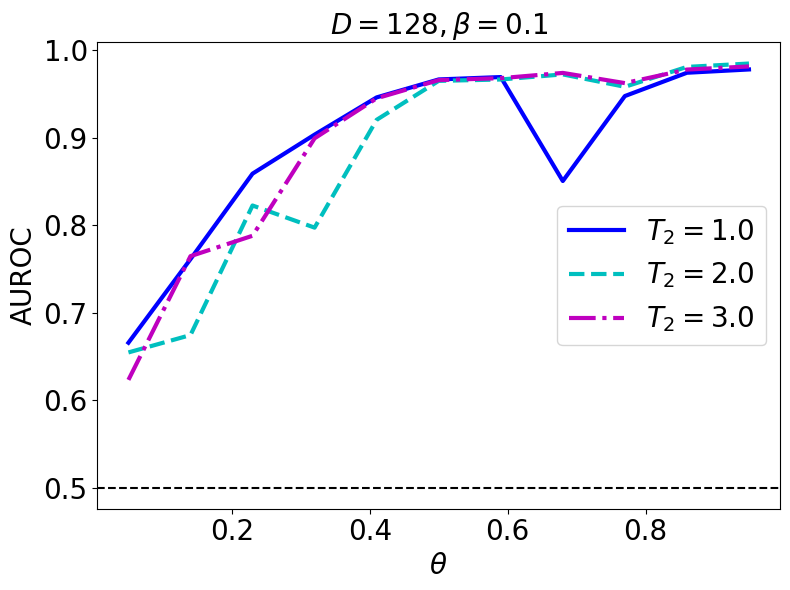

In [105]:
fig, ax = plt.subplots()

ax.set_title(r'$D=128, \beta=0.1$', fontsize=20)

ax.plot(auroc_df[1.0][0], auroc_df[1.0][1], 
        c='b', ls='-', lw=3.0,
        label='$T_2=1.0$')
ax.plot(auroc_df[2.0][0], auroc_df[2.0][1], 
        c='c', ls='--', lw=3.0,
        label='$T_2=2.0$')
ax.plot(auroc_df[3.0][0], auroc_df[3.0][1], 
        c='m', ls='-.', lw=3.0,
        label='$T_2=3.0$')

ax.axhline(y=0.5, c='k', ls='--')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel('AUROC', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20)

plt.show()


# Play with HOPE

In [35]:
G = nx.LFR_benchmark_graph(n=1_000, tau1=3, tau2=1.5, mu=0.1, average_degree=5, min_community=10, seed=10)

In [36]:
embeddings = HOPE(dimension=128, beta=0.2).train(G)

In [37]:
embeddings

{'0': array([-1.12266263e-01,  2.00836531e-02, -6.89498146e-02,  8.74981587e-02,
        -4.73696137e-02,  6.29611980e-02,  1.03288605e-01,  3.60675404e-03,
         2.80488050e-02, -7.75282156e-02,  7.30850510e-03,  8.23608140e-02,
         2.50318340e-02,  4.53236065e-02,  9.64796022e-02,  8.50253828e-02,
         5.93187625e-02,  1.57367417e-02, -1.22750167e-02,  1.08355736e-02,
        -2.61371108e-03,  1.05656704e-02, -2.97133625e-02, -7.04149373e-03,
        -1.30880664e-03,  1.31585468e-02,  1.48833587e-02, -5.27857538e-02,
         1.01426576e-01,  1.00084896e-02, -3.06740415e-01,  2.38347650e-01,
        -3.34040401e-01,  1.40201166e-01, -2.53164637e-01, -1.90598979e-01,
        -9.49286674e-05,  3.74514139e-01,  6.77004795e-04, -1.11605015e-01,
        -3.11507208e-03,  5.12836357e-01,  3.01358698e-03, -4.54097206e-02,
         1.96657660e-03,  2.24764084e-02, -1.22229701e-01,  8.25216805e-03,
         1.80587709e-01, -2.07380256e-01, -6.30064703e-03,  1.88509832e-02,
       

In [46]:
from src.utils.parameters import set_parameters_LE
from src.embed.LE import LE

In [47]:
params, hyperparams, _ = set_parameters_LE(maxiter=10_000)
hyperparams = hyperparams["embedding"]
params["k"] = 128

In [48]:
LE_emb = LE(G, params, hyperparams, per_component=True, nodelist=sorted(G.nodes()))

In [49]:
LE_emb

{0: array([-0.00722804, -0.0068644 , -0.00236275, -0.00568619,  0.0129032 ,
         0.01970197, -0.01497257, -0.02429713,  0.00122774, -0.01343803,
         0.01978393,  0.0026184 ,  0.0258197 ,  0.01297399, -0.01174712,
        -0.0683829 ,  0.11185261, -0.03521176,  0.01001344,  0.0738751 ,
        -0.00464347,  0.01216817, -0.00583157, -0.03313228, -0.01802498,
        -0.0070972 ,  0.00192429,  0.04111586, -0.0108158 , -0.01081728,
         0.02151931, -0.02106253,  0.0102635 , -0.00366711,  0.00537099,
        -0.0013969 ,  0.04850119, -0.09087178,  0.05031781, -0.01940591,
        -0.01083133, -0.0266935 ,  0.01368614,  0.09012684,  0.11281821,
         0.07196607, -0.06648351, -0.19758778, -0.09079782,  0.02421737,
         0.0080875 , -0.00296567, -0.03240832, -0.03583862,  0.04905822,
        -0.00975895, -0.00562635, -0.01732302,  0.00461825,  0.05285357,
         0.05975844,  0.00494721, -0.08364726, -0.03466889,  0.00977705,
         0.02355016,  0.09422308,  0.0326645 ,  